## Analysis of October 2022 CSBF Thermovac Calibration ##

Find all the relevant pictures, the calibrator temp and the camera temp and make a calibration model.

In [1]:
#%matplotlib tk
import matplotlib.pyplot as plt
import numpy as np
import array
from datetime import datetime as dt
import bz2, glob, datetime, sys, os, argparse, json
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool

Setup environment of data and runs

In [2]:
# picture dimensions
width=640
height=480
size = width * height

header=0

# directory for pictures, logs and logger output
#root_directory = os.environ['CAMERA_DATA']
root_directory = "TV_Run"
# file that contains the information on pictures in the run.
run_points = "TV_run_points.json"

Make a pictures class. 
1. Initialization generates an information dict. It has info on data within the times set by a json file
1. Plot timeline plots the data as a function of time
1. Data_set grabs one set of data and returns images, cal and cam temperature arrays

In [3]:
class pictures(object):
    def __init__(self,directory):
        self.directory = directory
        image_files = glob.glob(self.directory+"/cam*")
        log_files = glob.glob(self.directory+"/ucs_log.*")
        shm_files = glob.glob(self.directory+"/*_ucs_log.json.bz2")
        # setup for sorting by time
        def sort_criterion(in_dict):
            return in_dict['dtime'].timestamp()
        
        # make a list of the temperature points from the json file taken from the run comments
        
        with open(run_points,'r') as file:
            points_list = json.load(file)
        points = [] # a list of dicts containing the temperature points start and stop times.
        for i,point in enumerate(points_list):
            points.append({'n': i, 'st':dt.strptime(point['start']+'+0000','%Y-%m-%d %H:%M:%S%z'),
                        'et':dt.strptime(point['stop']+'+0000','%Y-%m-%d %H:%M:%S%z'),
                          'tcal': point['cal'], 'tcam': point['cam']})
        
        # make a list of dicts with time and temps from the .shm files
        
        temp_list = []
        for shm in shm_files:
            with bz2.open(shm,'r') as file:
                state_dict = json.load(file)
                fs = os.path.basename(shm).split('_')
                dtime = dt.strptime(fs[0]+fs[1]+'+0000', '%Y%m%d%H%M%S%z')
                temp_list.append({'dtime': dtime,
                                  'tcal': state_dict['cal_object1'],
                                 'tcam': state_dict['cam_object1'],
                                 'pressure': state_dict['i2c_hscp']})
        temp_list.sort(key = sort_criterion)
                
        
        # Run through the image files and generate a list of dicts with a bunch of info:
        #   1. filename.
        #   2. a datetime object with the time of the image.
        #   3. the number of the run point the image is in (what cal and cam temperatures), 0 if not within a test time.
        #   4. the linearly interpolated cal and cam temperatures between shm data.
        
        self.d = {'cam1':[],'cam2':[]} # dict containing lists of images within the times of the points for each camera
        for file in image_files:
            fs = os.path.basename(file).split('_')
            dtime = dt.strptime(fs[1]+fs[2]+"+0000", '%Y-%m-%d%H-%M-%S%z')
            image = {'name': file, 'dtime': dtime, 'point': 0}
            self.d[fs[0]].append(image)
        
        for cam in self.d: # loop over cameras
            self.d[cam].sort(key = sort_criterion) # sort the files by time.
            for j,image in enumerate(self.d[cam]): # loop over images for this camera
                for point in points: # loop over the temperature setpoints for the run
                    if point['st'] < image['dtime'] and point['et'] > image['dtime']: # if the image is with the time range
                        image['point'] = point['n'] # set mark the image as being within this temp setpoint
                        for i,temp in enumerate(temp_list): # loop over Shared Memory logs
                            if temp['dtime'] > image['dtime'] and temp['dtime'] < temp_list[i+1]['dtime']: # if the image time is just after the log time
                                self.d[cam][j]['pressure'] = temp['pressure']['value']
                                for t in ('tcal','tcam'): # loop over cal and cam !!! CAL times are screwed up for now. just use cam times
                                    dt_shm = temp['tcam']['time'] - temp_list[i-1]['tcam']['time'] # find the interval between cam or cal temperature readings
                                    dt_point = temp['tcam']['time'] - image['dtime'].timestamp() # find the time between the log time and the image time
                                    r = dt_point/dt_shm # the ratio
                                    self.d[cam][j][t] = r * (temp_list[i-1][t]['value'] - temp[t]['value'])\
                                        + temp[t]['value'] # linearly interpolate the temperature at the time of the image.
                                break
                        break
    def plot_timeline(self,data):
        x=[]
        y1=[]
        y2=[]
        for image in self.d[cam]:
            if image['point'] != 0 and image['pressure'] < 100.:
                x.append(image['dtime'])
                y1.append(image['tcal'])
                y2.append(image['tcam'])
        plt.figure(i,figsize=(10.,6.))
        plt.plot_date(x,y1,'b.',label = 'Tcal')
        plt.plot_date(x,y2,'r.',label = 'Tcam')
        plt.legend()
        plt.title('CSBF TV run {:}'.format(cam))
        plt.xlabel('Time')
        plt.ylabel('Temperature (C)')
    def data_set(self,cam,temp_point,pixel,p_low, p_high):
        x = []
        y = []
        z = []
        parray = []
        for image in self.d[cam]:
            if image['point'] in temp_point and p_low < image['pressure'] and p_high > image['pressure']:
                b = array.array("H")
                with bz2.open(image['name'], 'rb') as f:
                    b.fromfile(f,size)
                i = np.array(b,dtype = np.double)
                n = i[pixel]
                if n > 15000:
                    z.append(n)
                    x.append(image['tcal'])
                    y.append(image['tcam'])
                    parray.append(i)
        # setup the design matix parameters and the stack of images to return
        pdata = [x, y, z]
        parray = np.stack(parray).transpose()
        return pdata, parray
    def setup_fit(self):
        temp_point = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)
        self.data = {'cam1':{}, 'cam2': {}}
        for cam in self.data:
            self.data[cam] = {'low':{'lim': (-2., 100.)},'high':{'lim': (100., 1000.)}}
            for pres in self.data[cam]:
                pdata, parray = self.data_set(cam,temp_point, 40001, 
                                               self.data[cam][pres]['lim'][0], 
                                               self.data[cam][pres]['lim'][1])
                self.data[cam][pres] = {'d': pdata,'a': parray}
        return
    def fit_data(self):
        for cam in self.data:
            for pres in self.data[cam]:
                #d = data[cam][pres]['d']
                d = np.array(self.data[cam][pres]['d']).transpose()
                # Make the design matrix, same for all pixels.

                A = np.c_[d[:,0], d[:,1], np.ones(d.shape[0])]
                # setup array for fit parameters
                self.data[cam][pres]['C'] = np.zeros((size,3))
                #for i in range(size):
                #    C,_,_,_ = scipy.linalg.lstsq(A, self.data[cam][pres]['a'][i,:])    # coefficients
                #    self.data[cam][pres]['C'][i,:] = C
                for i in range(size):
                    des = self.data[cam][pres]['a'][i,:]
                    self.data[cam][pres]['C'][i,:] = self.fit_pix(i, A, des)
        return
    def fit_pix(self,i, A, des):
        C,_,_,_ = scipy.linalg.lstsq(A, des)
        return C
 

Get the pictures dictionary

In [4]:
p = pictures(root_directory)
#p.plot_timeline()

Grab the data for each camera and each pressure for 4 data sets

In [5]:
p.setup_fit()
p.fit_data()

Plot an image of each of 3 parameters for each of 4 data sets

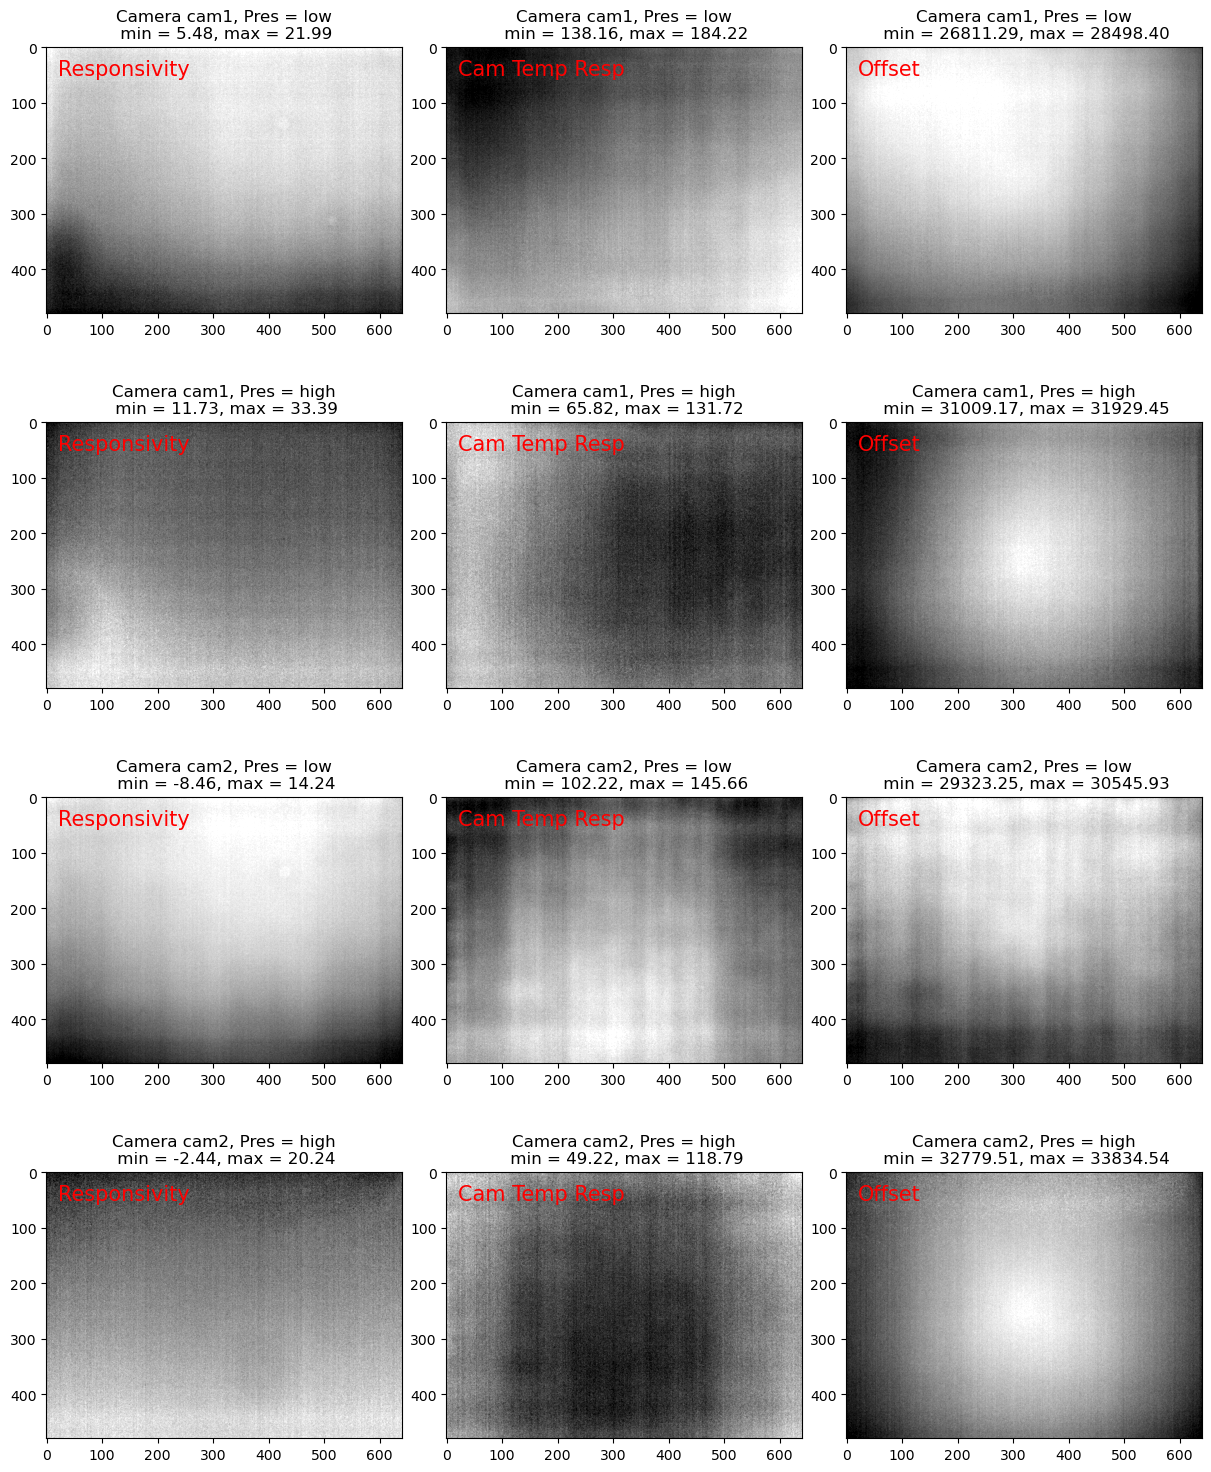

In [6]:
fig, axs = plt.subplots(num = 0, figsize = (12.,15.), nrows = 4, ncols = 3, constrained_layout=True)
i = 0
word = ['Responsivity', 'Cam Temp Resp', 'Offset']
for cam in p.data:
    for pres in p.data[cam]:
        for k in range(3):
            ax = axs.flat[i]
            minimage = np.min(p.data[cam][pres]['C'][:,k])
            maximage = np.max(p.data[cam][pres]['C'][:,k])
            delimage = maximage - minimage
            ax.imshow(p.data[cam][pres]['C'][:,k].reshape((height,width)),cmap='gray',
                       vmin=minimage+0.1*delimage,
                       vmax=maximage-0.1*delimage)
            ax.set_title('Camera {:}, Pres = {:}\n min = {:.2f}, max = {:.2f}'.format(cam, pres, minimage, maximage))
            ax.text(20.,50.,word[k], color = 'red', fontsize = 15)
            i += 1
plt.savefig('TV_Run_Result.pdf')

Make a 3-D plot for one pixel for the temps as independent parameters and the camera output as dependent.

In [ ]:
# plot points and fitted surface
for i, cam in enumerate(p.data):
    fig = plt.figure(i+1, figsize = (10.,10.))
    ax = fig.add_subplot(projection='3d')
    for pres in p.data[cam]:
        npts = 20
        X,Y = np.meshgrid(np.linspace(min(p.data[cam][pres]['d'][1]),
                                      max(p.data[cam][pres]['d'][1]),npts))
        XX = X.flatten()
        YY = Y.flatten()
        c = 'r' if pres == 'low' else 'g'
        d = np.array(p.data[cam][pres]['d']).transpose()
        ax.plot_surface(p.data[cam][pres]['X'], p.data[cam][pres]['Y'],
                        p.data[cam][pres]['Z'], rstride=1, cstride=1, alpha=0.2)
        #ax.scatter(data[cam][pres]['d'][:,0], data[cam][pres]['d'][:,1], data[cam][pres]['d'][:,2], c=c, s=50)
        ax.scatter(d[:,0], d[:,1], d[:,2], c=c, s=50)
    plt.title('Camera {:}'.format(cam))
    plt.xlabel('Tcal (C)')
    plt.ylabel('Tcam (C)')
    ax.set_zlabel('Output (Counts)')
    ax.axis('auto')
    ax.axis('tight')
    with plt.ion():
        for az in np.arange(0.,358.,2.):
            ax.view_init(azim = az,elev = 20)
            plt.draw()
            plt.pause(0.01)
    plt.close(fig = i)
